# RECOMMENDER SYSTEMS

A recommender system is a type of information filtering system that predicts or suggests items or preferences to users based on their preferences or behavior. It helps users discover items they might like, such as movies, products, music, articles, etc

## Types of Recommender Systems:

### **1. Collaborative Filtering:**
Collaborative Filtering predicts a user's preferences based on the preferences of other users.

There are two main types:



#### **User-Based Collaborative Filtering:**
This method finds similar users to the target user and recommends items liked by those similar users.

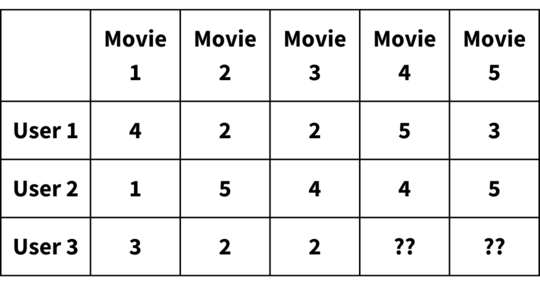

#### **Item-Based Collaborative Filtering:**
This method finds similar items based on user preferences and recommends items similar to those the user has liked before.

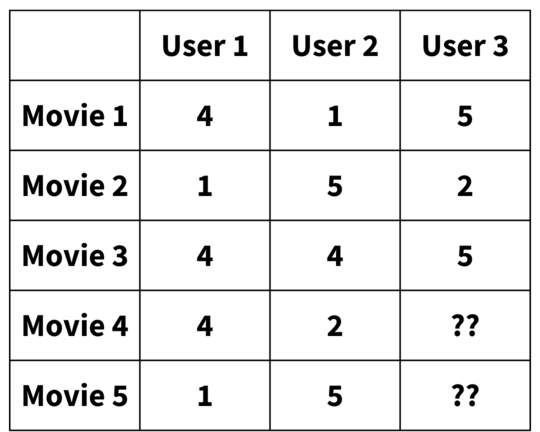

Note: Item-to-Item Collaborative filtering works generally much better than the user-based collaborative filtering and the
reason for this is generally you would see that there are lot more users in a system then the number of products or categories in that system also user preferences are dynamic and something that you might like in your early teens that you might not like it growing older whereas in an item to item method the item stays the same irrespective of the time.

## **2. Content-Based Filtering:**
Content-Based Filtering recommends items similar to those a user has liked before. It uses item features to recommend similar items.

### Similarity Measures.

Every RS needs some kind of category, technically it's calle an Embedding. An Embedding is a cluster of vectors(users or items) that are related.
For RS to perform well, they have to measure how the siminilarity between each embedding.

The Similarity measure of an RS is a function (s) ==> E x E --> R, that takes a pair of embeddings and returns a scalar measuring their similarity

To determine the degree of similarity, most recommendation systems rely on one or more of the following:

* cosine similarity
* dot product
* Euclidean distance

## Anime Dataset

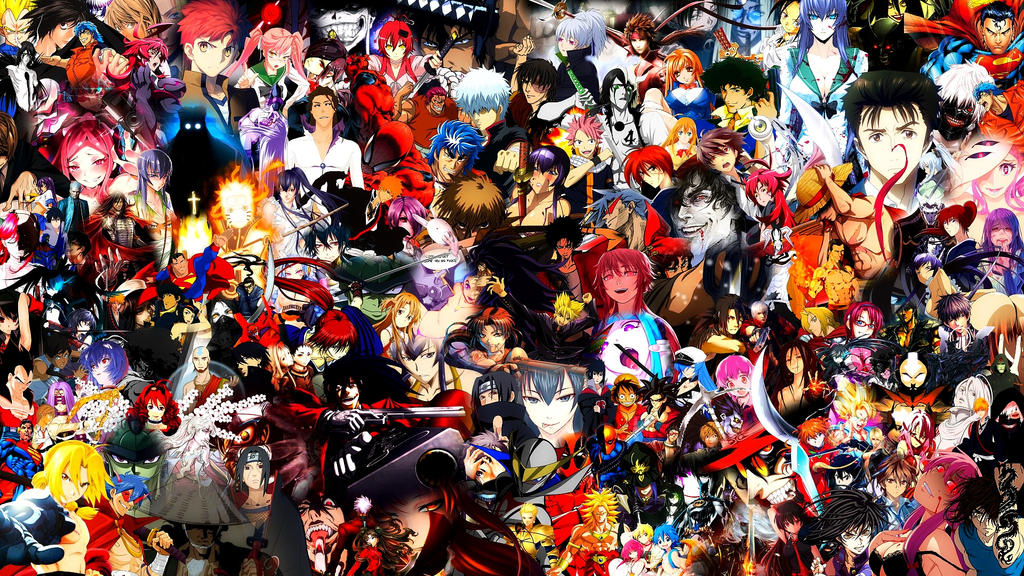

#### About the Dataset

### Context
This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

### Content

Anime.csv

* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's
"group".


Rating.csv

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).


### Data Preparation


In [ ]:
# Import needed modules
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator

In [ ]:
# Load the anime dataset
anime_df = pd.read_csv('/content/sample_data/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
# Load the rating dataset
rating_df = pd.read_csv('/content/sample_data/rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### **Data Preprocessing**
- Before building the recommendation system, we need to preprocess the data, which includes handling missing values and drop duplicated items.

In [ ]:
# For computing reasons I'm limiting the dataframe length to 10,000 users
rating_df = rating_df[rating_df.user_id <= 10000]

In [ ]:
# Preprocess the rating dataset (handle -1 ratings as NaN)
rating_df['rating'] = rating_df['rating'].replace(-1, np.nan, inplace=True)

<ipython-input-25-ca04d489cde0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['rating'] = rating_df['rating'].replace(-1, np.nan, inplace=True)
<ipython-input-25-ca04d489cde0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['rating'] = rating_df['rating'].replace(-1, np.nan, inplace=True)


In [ ]:
# Delete duplicated items
rating_df = rating_df.drop_duplicates(['user_id', 'anime_id'])

In [ ]:
# Create a user-item interaction matrix
user_item_matrix = rating_df.pivot(index='user_id', columns='anime_id', values='rating')

In [ ]:
user_item_matrix.head(5)

anime_id,1,5,6,7,8,15,16,17,18,19,...,34048,34085,34103,34107,34136,34173,34240,34283,34324,34325
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,None,NaN,NaN,None,NaN,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **3. User-Based Collaborative Filtering**
**User Similarity**
- To implement user-based collaborative filtering, we need to calculate the similarity between users based on their ratings. We can use similarity metrics such as cosine similarity or Pearson correlation.

In [ ]:
# Calculate user similarity using cosine similarity
user_similarity = cosine_similarity(user_item_matrix.fillna(0))

**Making Recommendations**
- To make recommendations for a target user, we identify users similar to the target user and recommend anime that they have rated positively.

In [ ]:
def user_based_recommendations(user_id, user_item_matrix, user_similarity, n=5):
    # Get the similarity scores for the target user
    user_scores = user_similarity[user_id - 1]

    # Sort users by similarity in descending order
    similar_users = sorted(enumerate(user_scores), key=lambda x: x[1], reverse=True)

    # Initialize a list to store recommended anime
    recommended_anime = []

    for user, score in similar_users[1:]:  # Exclude the target user
        # Get the anime the similar user has rated positively
        rated_anime = user_item_matrix.loc[user_item_matrix.index[user - 1]]
        positively_rated_anime = rated_anime[rated_anime >= 6].index

        # Exclude anime the target user has already rated
        target_user_rated_anime = user_item_matrix.loc[user_id].dropna().index
        recommended_anime.extend(set(positively_rated_anime) - set(target_user_rated_anime))

        # Limit the number of recommendations
        if len(recommended_anime) >= n:
            break

    return recommended_anime[:n]


In [ ]:
recommended_anime

# **4. Item-Based Collaborative Filtering**
**Item Similarity**
- To implement item-based collaborative filtering, we calculate the similarity between anime based on user ratings.

In [ ]:
# Calculate item similarity using cosine similarity
item_similarity = cosine_similarity(user_item_matrix.fillna(0).T)

**Making Recommendations**
- To make item-based recommendations, we identify anime similar to those the user has already rated positively.

In [ ]:
def item_based_recommendations(user_id, user_item_matrix, item_similarity, n=5):
    # Get the anime the user has rated positively
    positively_rated_anime = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] >= 6].index

    # Initialize a list to store recommended anime
    recommended_anime = []

    for anime_id in positively_rated_anime:
        # Get anime similar to the liked anime
        similar_anime = item_similarity[anime_id - 1]

        # Sort similar anime by similarity in descending order
        similar_anime_sorted = sorted(enumerate(similar_anime), key=lambda x: x[1], reverse=True)

        for anime, score in similar_anime_sorted[1:]:  # Exclude the liked anime
            # Exclude anime the user has already rated
            user_rated_anime = user_item_matrix.loc[user_id].dropna().index
            if anime not in user_rated_anime:
                recommended_anime.append(anime)

            # Limit the number of recommendations
            if len(recommended_anime) >= n:
                break

    return recommended_anime[:n]

# **5. Test Recommendation System**

In [ ]:
# Choose a user ID for testing
user_id = 9  # Replace with the user ID you want to test

# Test user-based recommendations
user_recommendations = user_based_recommendations(user_id, user_item_matrix, user_similarity, n=5)

# Test item-based recommendations
item_recommendations = item_based_recommendations(user_id, user_item_matrix, item_similarity, n=5)


In [ ]:
# Display the recommendations
print(f"User-Based Recommendations for User {user_id}:")
for anime_id in user_recommendations:
    anime_name = anime_df.loc[anime_df['anime_id'] == anime_id, 'name'].values[0]
    print(f"- {anime_name}")

print(f"\nItem-Based Recommendations for User {user_id}:")
for anime_id in item_recommendations:
    anime_name = anime_df.loc[anime_df['anime_id'] == anime_id, 'name'].values[0]
    print(f"- {anime_name}")

Let's see another example

### The Imdb Movie Dataset Example

import libraries

In [ ]:
import pandas as pd
import numpy as np

load the dataset

In [ ]:
df1=pd.read_csv('/content/sample_data/tmdb_5000_credits.csv')
df2=pd.read_csv('/content/sample_data/tmdb_5000_movies.csv')

In [ ]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [ ]:
df2.head(5)

#Now, For Recommnder systems, there are two main types.
## 1. Collaborative Filtering
## 2. Content Filtering.
### I will also a basic filtering that recommends movies based on thier similarites using average.

# **Basic Filtering** -
  This simple recommender will be built based on best rated movie. To do this we need a score for movie rating.
I'll be using IMDB's weighted rating fromular (wr) = ((v/v+m)R) + ((m/v+m)C)

where,
* v is the number of votes for the movie = vote_count
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie = vote average
* C is the mean vote across the whole report = mean of vote average



# **Basic Filtering** -
  This simple recommender will be built based on best rated movie. To do this we need a score for movie rating.
I'll be using IMDB's weighted rating fromular (wr) = ((v/v+m)R) + ((m/v+m)C)

where,
* v is the number of votes for the movie = vote_count
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie = vote average
* C is the mean vote across the whole report = mean of vote average



In [ ]:
C= df2['vote_average'].mean()
C

for the minimum votes required to be listed on the chart, it should have at least 90% movies on the list.


In [ ]:
m= df2['vote_count'].quantile(0.9)
m

Now, we can filter out the movies that qualify for the chart

In [ ]:
filtered_movies = df2.copy().loc[df2['vote_count'] >= m]
filtered_movies.shape

define **weighted_rating()** and define a new feature **score**


In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
filtered_movies['score'] = filtered_movies.apply(weighted_rating, axis=1)

Sorting the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [ ]:
#Sort movies based on score calculated above
filtered_movies = filtered_movies.sort_values('score', ascending=False)

#Print the top 15 movies
filtered_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

Lets sort through with popularity.

In [ ]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


This is a basic recommender system  

# **Content Based Filtering**

For this type of recommender system, the overview, cast, crew, keyword, tagline etc (content of dataset) is used to find similarity with other movies.




In [ ]:
df2['overview'].head(5)

For each overview, I will find its Term Frequency-Inverse Document Frequency with scikit-learn, read more about it here.



This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.


In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

Compute a similarity score with the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity).


Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()


In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather')

In [ ]:
get_recommendations('Man of Steel')

In [ ]:
get_recommendations('Superman Returns')

If you notice, man of steel and superman didnt recommend one another although they're almost the same movie.

The quality of this recommender cann be improved by adding more features. So from the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie.
First we convert the dataset into a usable data

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

Function to extract the required information from each feature.

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[features] = df2[features].apply(get_list)

In [ ]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [ ]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

We can now reuse our **get_recommendations()** function by passing in the new **cosine_sim2** matrix as your second argument.

In [ ]:
get_recommendations('Man of Steel', cosine_sim2)